# Evaluate "LLM as a Judge" for Summarization 2.2

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns

# Configure Matplotlib for inline display
%matplotlib inline

In [113]:
# Choose which llm-as-a-judge data to evaluate
common_path = "../../data/evaluations/"

transcripts_version = "1.0"
llm_judge_file = f'summaries_{transcripts_version}_evaluation_2.2_split.csv'
llm_data = pd.read_csv(common_path + llm_judge_file)
# additional wrangling: use `orthopnea_agree` an AND operation to combine into `current_symptoms_agree`
llm_data['current_symptoms_agree'] = llm_data['current_symptoms_agree'] & llm_data['orthopnea_agree']
llm_data['current_symptoms_agree_reasoning'] = llm_data['current_symptoms_agree_reasoning'] + ' ' + llm_data['orthopnea_agree_reasoning']
# additional wrangling: combine `no_normality` and `no_stability` into `no_diagnose`
llm_data['no_diagnose'] = llm_data['no_diagnose'] & llm_data['no_normality'] & llm_data['no_stability']
llm_data['no_diagnose_reasoning'] = llm_data['no_diagnose_reasoning'] + ' ' + llm_data['no_normality_reasoning'] + ' ' + llm_data['no_stability_reasoning']

# This is from our sweat blood and tears
human_data = pd.read_csv(common_path + '2024-07-24-human-judge-summarization.csv')
human_data.rename(
    columns={
        "intro_patient": "intro_patient_present",
        "current_symptoms": "current_symptoms_present",
        "vital_signs": "vital_signs_present",
        "medications": "medications_present",
        "summary_overview": "summary_overview_present",
        "symptoms_agree": "current_symptoms_agree",
        "meds_agree": "medications_agree",
    },
    inplace=True,
)

# Ensure that the transcript numbers are exactly matched, and are in the same order
llm_data = llm_data.sort_values(by='transcript_number', ascending=False).reset_index(drop=True)
human_data = human_data.sort_values(by='transcript_number', ascending=False).reset_index(drop=True)
assert (llm_data['transcript_number'] == human_data['transcript_number']).all()

In [114]:
# display(llm_data.head())

# print all unique values for each column
for col in llm_data.columns:
    if ("_reasoning" not in col) and (col not in ["transcript_number", "observations"]):
        print(col, llm_data[col].unique())

intro_patient_present [1]
current_symptoms_present [1]
current_symptoms_agree [1 0]
orthopnea_agree [1 0]
vital_signs_present [1]
vital_signs_agree [0 1]
medications_present [1]
medications_agree [1 0]
summary_overview_present [1]
no_diagnose [0 1]
no_normality [0 1]
no_stability [1 0]


In [115]:
# display(human_data.head())

# print all unique values for each column
for col in human_data.columns:
    if ("_reasoning" not in col) and (col not in ["transcript_number", "observations"]):
        print(col, human_data[col].unique())

intro_patient_present [1]
current_symptoms_present [1]
vital_signs_present [1]
medications_present [1]
summary_overview_present [1]
current_symptoms_agree [1 0]
vital_signs_agree [0 1]
medications_agree [1 0]
no_diagnose [1 0]


In [116]:
question_categories = {
    "report_content": ["intro_patient_present", "current_symptoms_present", "vital_signs_present", "medications_present", "summary_overview_present"],
    "report_accuracy": ["current_symptoms_agree", "vital_signs_agree", "medications_agree"],
    "report_quality": ["no_diagnose"],
}

feature_columns = [v for values in question_categories.values() for v in values]

/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Libra

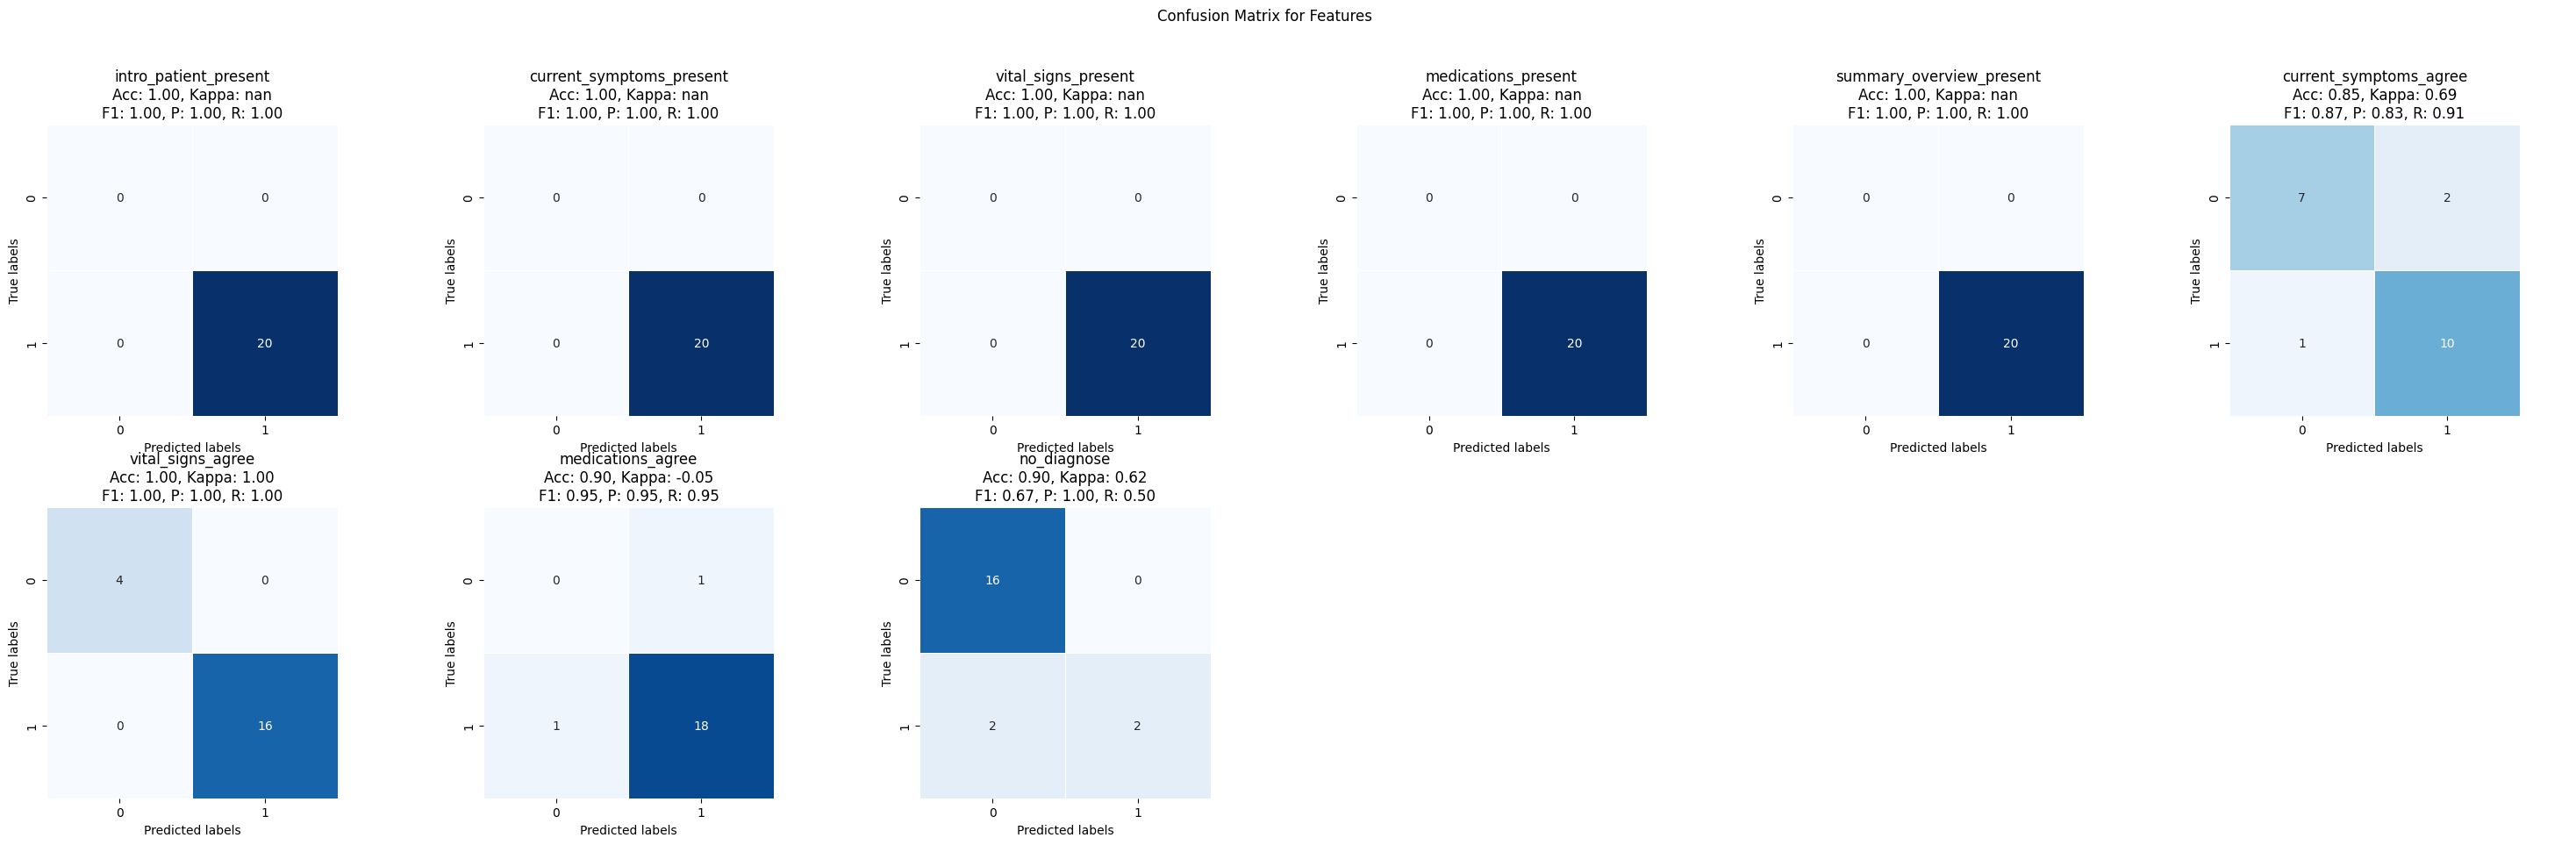

In [117]:
def calculate_metrics(data_true: pd.DataFrame, data_pred: pd.DataFrame, columns: list[str]):
    metrics = {}
    for col in columns:
        tp = np.sum((data_true[col] == 1) & (data_pred[col] == 1))
        tn = np.sum((data_true[col] == 0) & (data_pred[col] == 0))
        fp = np.sum((data_true[col] == 0) & (data_pred[col] == 1))
        fn = np.sum((data_true[col] == 1) & (data_pred[col] == 0))
        accuracy = accuracy_score(data_true[col], data_pred[col])
        kappa = cohen_kappa_score(data_true[col], data_pred[col])
        precision = precision_score(data_true[col], data_pred[col], zero_division=0)
        recall = recall_score(data_true[col], data_pred[col], zero_division=0)
        f1 = f1_score(data_true[col], data_pred[col], zero_division=0)

        metrics[col] = {
            'conf_matrix': [[tn, fp], [fn, tp]],
            'accuracy': accuracy,
            'kappa': kappa,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    return metrics


def plot_confusion_matrices(metrics, nrows, ncols, main_title='Confusion Matrices'):
    # figure out the color scale first
    max_val = max([np.array(v['conf_matrix']).max() for v in metrics.values()])
    min_val = min([np.array(v['conf_matrix']).min() for v in metrics.values()])

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    plt.suptitle(main_title)
    axes = axes.flatten()

    for i, (col, data) in enumerate(metrics.items()):
        sns.heatmap(
            data['conf_matrix'],
            annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', ax=axes[i], cbar=False,
            vmin=min_val, vmax=max_val
        )
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        axes[i].set_title(f'{col}\nAcc: {data["accuracy"]:.2f}, Kappa: {data["kappa"]:.2f}\nF1: {data["f1"]:.2f}, P: {data["precision"]:.2f}, R: {data["recall"]:.2f}')

    # Hide any unused axes if there are any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

# Example usage
metrics = calculate_metrics(human_data, llm_data, feature_columns)
columns_per_row = 6
nrows = len(feature_columns) // columns_per_row + 1
ncols = columns_per_row
fig, axes = plot_confusion_matrices(metrics, nrows, ncols, main_title='Confusion Matrix for Features')
plt.show()


# def plot_confusion_matrix(data_true, data_pred, columns, nrows, ncols, main_title='Confusion matrices'):
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
#     plt.title(main_title)
#     axes = axes.flatten()

#     for i, col in enumerate(columns):
#         # cm = confusion_matrix(data_true[col], data_pred[col])
#         tp = np.sum((data_true[col] == 1) & (data_pred[col] == 1))
#         tn = np.sum((data_true[col] == 0) & (data_pred[col] == 0))
#         fp = np.sum((data_true[col] == 0) & (data_pred[col] == 1))
#         fn = np.sum((data_true[col] == 1) & (data_pred[col] == 0))
#         accuracy = accuracy_score(data_true[col], data_pred[col])
#         kappa = cohen_kappa_score(data_true[col], data_pred[col])
#         precision = precision_score(data_true[col], data_pred[col])
#         recall = recall_score(data_true[col], data_pred[col])
#         f1 = f1_score(data_true[col], data_pred[col])

#         sns.heatmap(
#             [[tn, fp], [fn, tp]],
#             annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', ax=axes[i], cbar=False,
#         )
#         axes[i].set_xlabel('Predicted labels');
#         axes[i].set_ylabel('True labels');
#         axes[i].set_title(f'{col}\nAcc: {accuracy:.2f}, Kappa: {kappa:.2f}\nF1: {f1:.2f}, P: {precision:.2f}, R: {recall:.2f}');

#     # Hide any unused axes if there are any
#     for j in range(i + 1, len(axes)):
#         axes[j].axis('off')

#     plt.tight_layout();

#     return fig, axes

# # Example usage for a specific column
# columns_per_row = 6
# fig, axes = plot_confusion_matrix(
#     human_data_renamed,
#     llm_data_renamed,
#     [c for c in llm_data_renamed.columns if c in feature_columns],
#     len(feature_columns) // columns_per_row + 1,
#     columns_per_row,
#     main_title=f'Confusion Matrix for LLM vs Human Judge: {llm_judge_file}'
# )


For `symptoms_agree`, we no longer get false positives! But, we're getting way more false negatives. Let's check it out.

In [118]:
# find out which summaries (transcript_number) are not matching.
# Input: two dataframes (pred, true), the column to compare
# Output: a dict {tuple (pred_values, true_values): [transcript_numbers]}

def find_mismatched_transcripts(data_true: pd.DataFrame, data_pred: pd.DataFrame, column: str):
    mismatched_transcripts = {}
    for i, (true_val, pred_val) in enumerate(zip(data_true[column], data_pred[column])):
        if true_val != pred_val:
            key = (pred_val, true_val)
            if key not in mismatched_transcripts:
                mismatched_transcripts[key] = []
            mismatched_transcripts[key].append(i)
    return mismatched_transcripts


mismatched_transcripts = find_mismatched_transcripts(human_data, llm_data, 'current_symptoms_agree')
print(mismatched_transcripts)

# print llm_judge rows for predicted value 1 and true value 0
# pred_val = 0; true_val = 1  # false negative
pred_val = 1; true_val = 0  # false positive

# pandas display settings
pd.set_option('display.max_colwidth', None)

filtered = llm_data.iloc[mismatched_transcripts[(pred_val, true_val)]][["transcript_number", "current_symptoms_agree", "current_symptoms_agree_reasoning"]]
display(filtered)
# copy transcript numbers to clipboard
filtered["transcript_number"].to_clipboard(index=False, header=False)

{(0, 1): [3], (1, 0): [10, 16]}


,transcript_number,current_symptoms_agree,current_symptoms_agree_reasoning
10,13912736,1,"Current symptoms in SUMMARY match TRANSCRIPT; criteria passed hence the score is 1 The patient states they do not need to prop up with pillows while lying down, and 'orthopnea' is not mentioned in 'current_symptoms'; criteria passed hence the score is 1"
16,12305811,1,"Current symptoms in SUMMARY match TRANSCRIPT; criteria passed hence the score is 1 The patient states they do not need pillows to prop up while lying down, and 'orthopnea' or 'pillows' is not mentioned in 'current_symptoms'; criteria passed hence the score is 1"


Analysis on `symptoms_agree`: still missing orthopnea

In [119]:
mismatched_transcripts = find_mismatched_transcripts(human_data, llm_data, 'no_diagnose')
print(mismatched_transcripts)

# print llm_judge rows for predicted value 1 and true value 0
pred_val = 0; true_val = 1  # false negative
# pred_val = 1; true_val = 0  # false positive

# pandas display settings
pd.set_option('display.max_colwidth', None)

llm_data.iloc[mismatched_transcripts[(pred_val, true_val)]][["transcript_number", "no_diagnose", "no_diagnose_reasoning"]]

{(0, 1): [0, 16]}


,transcript_number,no_diagnose,no_diagnose_reasoning
0,19557627,0,"The SUMMARY does not contain any interpretations or diagnoses; it only reflects the patient's words and experiences; criteria passed hence the score is 1 The SUMMARY mentions 'normal' in the context of vital signs, specifically stating 'temperature of 98.2 degrees'; criteria failed hence the score is 0 The SUMMARY does not mention 'stable' in the context of the patient's health; criteria passed hence the score is 1"
16,12305811,0,"The SUMMARY does not contain any interpretations or diagnoses; it only reflects the patient's words; criteria passed hence the score is 1 The SUMMARY does not mention 'normal' or 'within normal limits'; criteria passed hence the score is 1 The SUMMARY states 'your vital signs seem stable', which is a direct mention of 'stable'; criteria failed hence the score is 0"


,question,conf_matrix,accuracy,kappa,precision,recall,f1,category
0,intro_patient_present,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,report_content
1,current_symptoms_present,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,report_content
2,vital_signs_present,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,report_content
3,medications_present,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,report_content
4,summary_overview_present,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,report_content
5,current_symptoms_agree,"[[7, 2], [1, 10]]",0.85,0.693878,0.833333,0.909091,0.869565,report_accuracy
6,vital_signs_agree,"[[4, 0], [0, 16]]",1.0,1.0,1.0,1.0,1.0,report_accuracy
7,medications_agree,"[[0, 1], [1, 18]]",0.9,-0.052632,0.947368,0.947368,0.947368,report_accuracy
8,no_diagnose,"[[16, 0], [2, 2]]",0.9,0.615385,1.0,0.5,0.666667,report_quality


,category,accuracy
0,report_accuracy,0.916667
1,report_content,1.0
2,report_quality,0.9


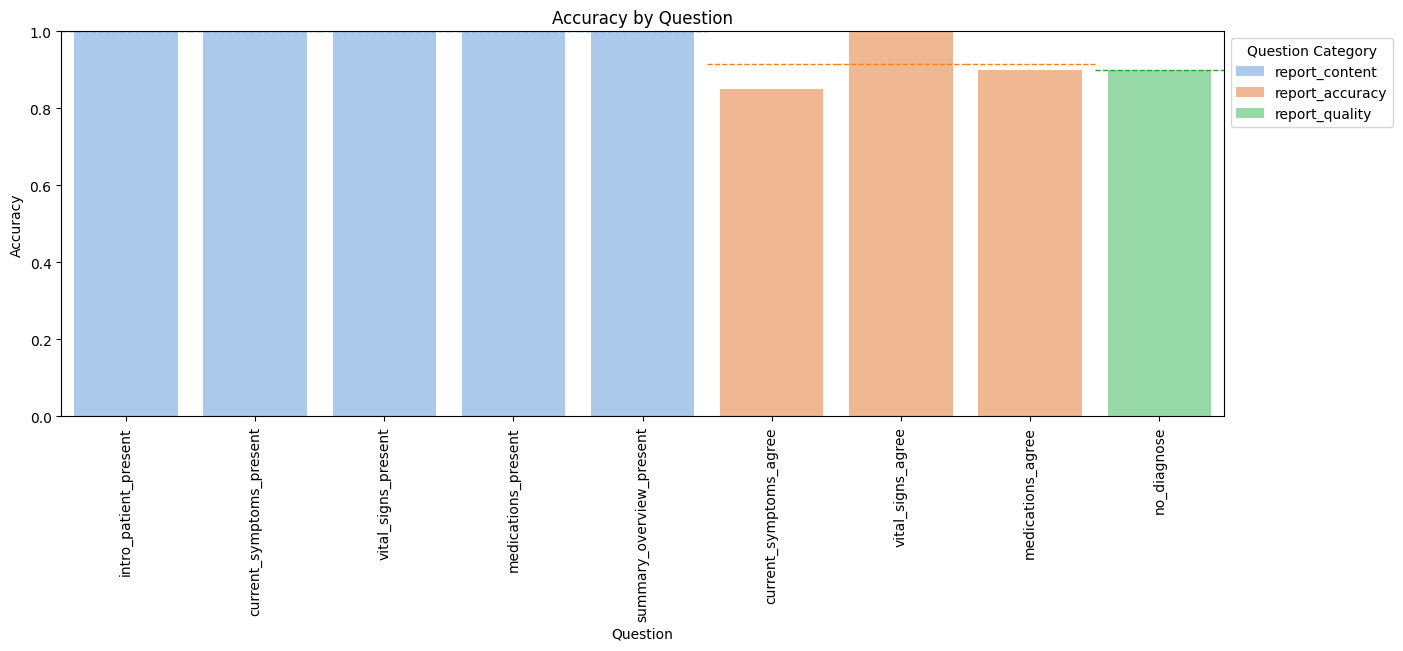

In [120]:
metric_to_plot = "accuracy"  # choose from "accuracy", "kappa", "precision", "recall", "f1"

df_accuracy = pd.DataFrame(metrics).T
df_accuracy["category"] = df_accuracy.index.map(
    lambda x: next((k for k, v in question_categories.items() if x in v), None)
)
df_accuracy.index.name = "question"
df_accuracy.reset_index(inplace=True)
display(df_accuracy)


# calculate average by category
df_accuracy_avg = df_accuracy.groupby("category")[metric_to_plot].mean().reset_index()
display(df_accuracy_avg)

# now plot metric by question
fig, ax = plt.subplots(figsize=(15, 5))

sns.barplot(data=df_accuracy, x="question", y=metric_to_plot, hue="category", ax=ax, palette="pastel")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Question Category")

# also plot the averages using dashed lines
sns.set_palette("tab10")
for i, question in enumerate(df_accuracy["question"]):
    category = df_accuracy.loc[df_accuracy["question"] == question, "category"].values[0]
    avg = df_accuracy_avg.loc[df_accuracy_avg["category"] == category, metric_to_plot].values[0]
    category_idx = df_accuracy["category"].unique().tolist().index(category)
    color = sns.color_palette()[category_idx]
    ax.plot([i - 0.5, i + 0.5], [avg, avg], color=color, linestyle="--", linewidth=1)

ax.set_xlim(-0.5, len(df_accuracy) - 0.5)
ax.set_ylim(0, 1)
ax.set_title(f"{metric_to_plot.capitalize()} by Question")
ax.set_ylabel(metric_to_plot.capitalize())
ax.set_xlabel("Question")
plt.xticks(rotation=90)

plt.show()